# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 18            
model_seed = 8           

# --- Training configuration ---
epochs = 200            

# --- Dataset configuration ---
base_data_size = 50      
dataset_type = "data"   
dataset_quantities = [0, 500-50, 2000 - 50, 5000 - 50, 20000 - 50, 50000 - 50]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the CIFAR-10 model module name
from minima_volume.models import CIFAR10_model_data as model_module  # <- your new module for CIFAR-10

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device=device
)

# CIFAR-10 MLP initialization parameters
# Since input dimension is higher, hidden layers can be larger
hidden_dims = [512, 256]  # adjust as desired

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = min(len(x_train), 1024)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=50,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/200: Train Loss 2.3059 | Test Loss 2.3261 | accs Train 0.1400 Test 0.1224


Epoch 50/200: Train Loss 0.0000 | Test Loss 10.3107 | accs Train 1.0000 Test 0.1851


Epoch 100/200: Train Loss 0.0000 | Test Loss 10.3875 | accs Train 1.0000 Test 0.1861


Epoch 150/200: Train Loss 0.0000 | Test Loss 10.3355 | accs Train 1.0000 Test 0.1863


Epoch 200/200: Train Loss 0.0000 | Test Loss 10.2899 | accs Train 1.0000 Test 0.1864
Completed training with 0 additional samples of data
Epoch 1/200: Train Loss 2.3051 | Test Loss 2.1723 | accs Train 0.1180 Test 0.2179


Epoch 50/200: Train Loss 0.0003 | Test Loss 5.1660 | accs Train 1.0000 Test 0.3105


Epoch 100/200: Train Loss 0.0001 | Test Loss 5.4180 | accs Train 1.0000 Test 0.3123


Epoch 150/200: Train Loss 0.0001 | Test Loss 5.4755 | accs Train 1.0000 Test 0.3117


Epoch 200/200: Train Loss 0.0001 | Test Loss 5.5284 | accs Train 1.0000 Test 0.3122
Completed training with 450 additional samples of data
Epoch 1/200: Train Loss 2.2449 | Test Loss 2.0690 | accs Train 0.1675 Test 0.2589


Epoch 50/200: Train Loss 0.0065 | Test Loss 3.4828 | accs Train 1.0000 Test 0.3747


Epoch 100/200: Train Loss 0.0016 | Test Loss 3.9783 | accs Train 1.0000 Test 0.3723


Epoch 150/200: Train Loss 0.0008 | Test Loss 4.2542 | accs Train 1.0000 Test 0.3719


Epoch 200/200: Train Loss 0.0004 | Test Loss 4.4522 | accs Train 1.0000 Test 0.3706
Completed training with 1950 additional samples of data
Epoch 1/200: Train Loss 2.1214 | Test Loss 1.9046 | accs Train 0.2344 Test 0.3195


Epoch 50/200: Train Loss 0.0067 | Test Loss 3.3002 | accs Train 1.0000 Test 0.4232


Epoch 100/200: Train Loss 0.0015 | Test Loss 3.8548 | accs Train 1.0000 Test 0.4214


Epoch 150/200: Train Loss 0.0006 | Test Loss 4.1929 | accs Train 1.0000 Test 0.4199


Epoch 200/200: Train Loss 0.0003 | Test Loss 4.4753 | accs Train 1.0000 Test 0.4171
Completed training with 4950 additional samples of data
Epoch 1/200: Train Loss 1.8669 | Test Loss 1.6677 | accs Train 0.3367 Test 0.4082


Epoch 50/200: Train Loss 0.0041 | Test Loss 3.2471 | accs Train 1.0000 Test 0.4999


Epoch 100/200: Train Loss 0.0008 | Test Loss 3.8429 | accs Train 1.0000 Test 0.4987


Epoch 150/200: Train Loss 0.0003 | Test Loss 4.2693 | accs Train 1.0000 Test 0.4972


Epoch 200/200: Train Loss 0.0001 | Test Loss 4.6228 | accs Train 1.0000 Test 0.4973
Completed training with 19950 additional samples of data
Epoch 1/200: Train Loss 1.7155 | Test Loss 1.5275 | accs Train 0.3925 Test 0.4587


Epoch 50/200: Train Loss 0.0030 | Test Loss 3.3548 | accs Train 1.0000 Test 0.5554


Epoch 100/200: Train Loss 0.0005 | Test Loss 3.8424 | accs Train 1.0000 Test 0.5544


Epoch 150/200: Train Loss 0.0001 | Test Loss 4.2929 | accs Train 1.0000 Test 0.5532


Epoch 200/200: Train Loss 0.9982 | Test Loss 1.4700 | accs Train 0.6411 Test 0.5102
Completed training with 49950 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 10.2899 | accs: 0.1864
 450 samples | Test Loss: 5.5284 | accs: 0.3122
1950 samples | Test Loss: 4.4522 | accs: 0.3706
4950 samples | Test Loss: 4.4753 | accs: 0.4171
19950 samples | Test Loss: 4.6228 | accs: 0.4973
49950 samples | Test Loss: 1.4700 | accs: 0.5102

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  450 | Train Loss: 0.0001 | accs: 1.0000
 Model 1950 | Train Loss: 0.0004 | accs: 1.0000
 Model 4950 | Train Loss: 0.0003 | accs: 1.0000
 Model 19950 | Train Loss: 0.0001 | accs: 1.0000
 Model 49950 | Train Loss: 0.9428 | accs: 0.6600

Dataset type: data, additional samples: 450
 Model    0 | Train Loss: 9.1088 | accs: 0.2580
 Model  450 | Train Loss: 0.0001 | accs: 1.0000
 Model 1950 | Train Loss: 0.0004 | accs: 1.0000
 Model 4950 | Train Loss: 0.0003 | accs: 1.0000
 Model 19950 | Train Loss: 0.0001 | accs: 1.0000
 Model 49950 | Tra

 Model    0 | Train Loss: 10.2708 | accs: 0.1898
 Model  450 | Train Loss: 5.5340 | accs: 0.3200
 Model 1950 | Train Loss: 4.3164 | accs: 0.4015
 Model 4950 | Train Loss: 4.0939 | accs: 0.4772
 Model 19950 | Train Loss: 2.8121 | accs: 0.6960


 Model 49950 | Train Loss: 0.9507 | accs: 0.6586


### Model + Data Specific Verification

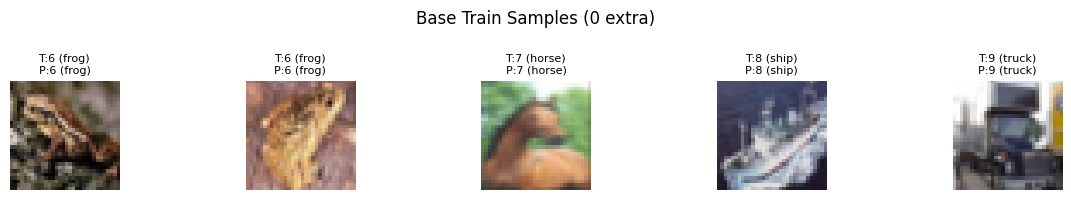

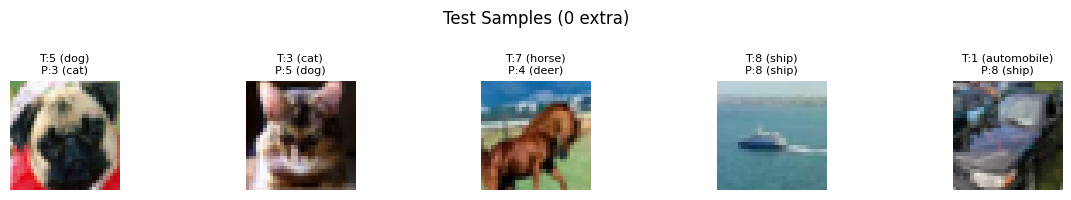

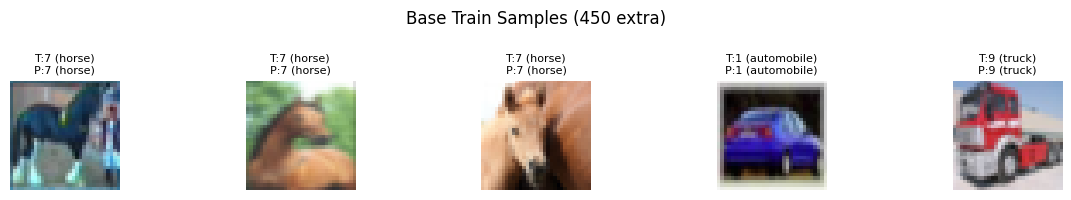

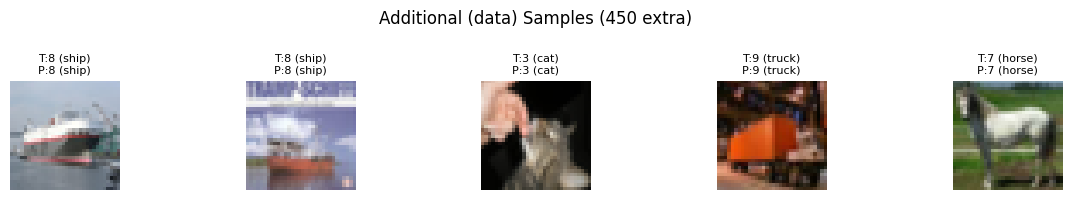

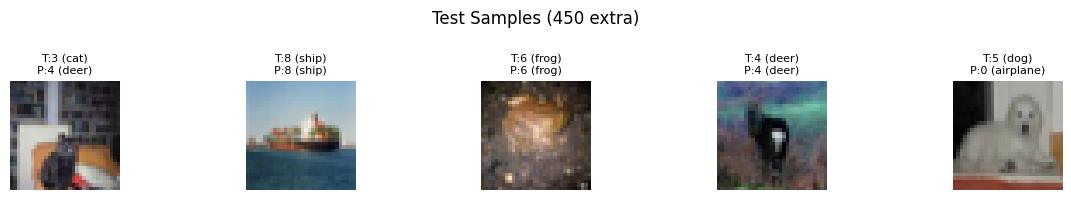

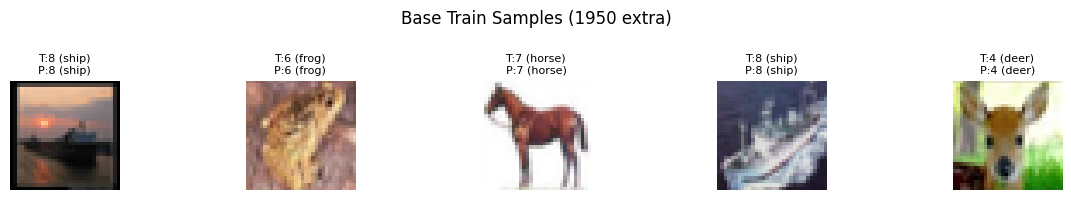

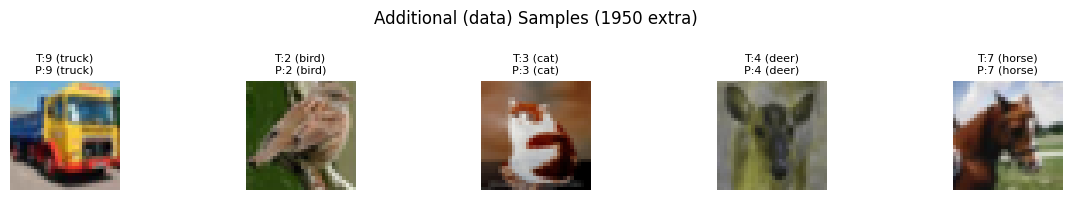

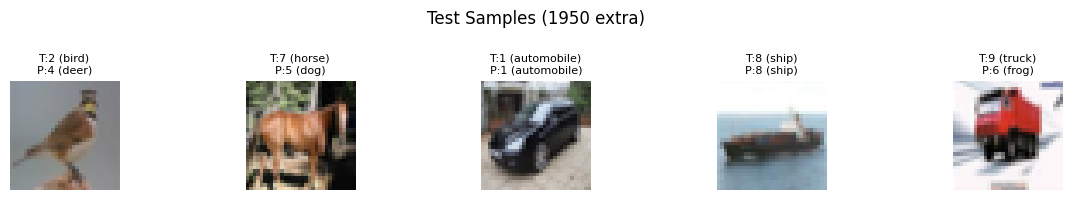

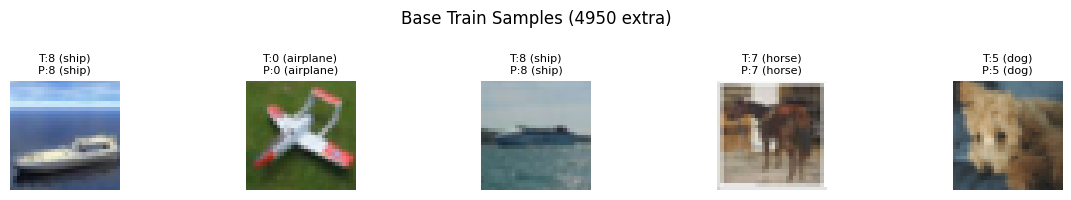

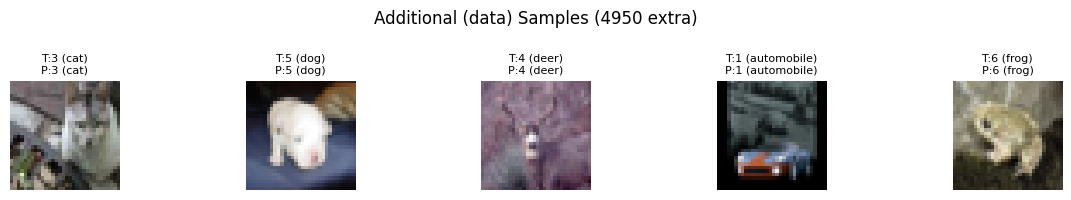

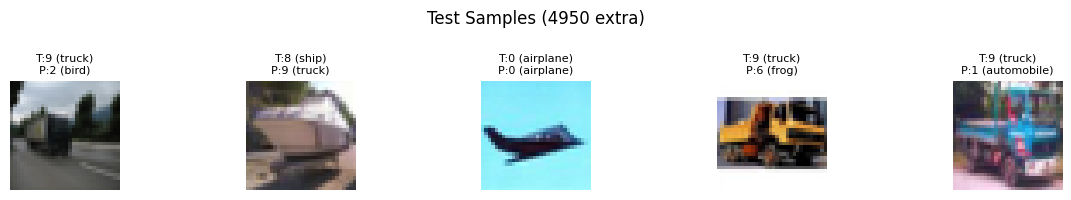

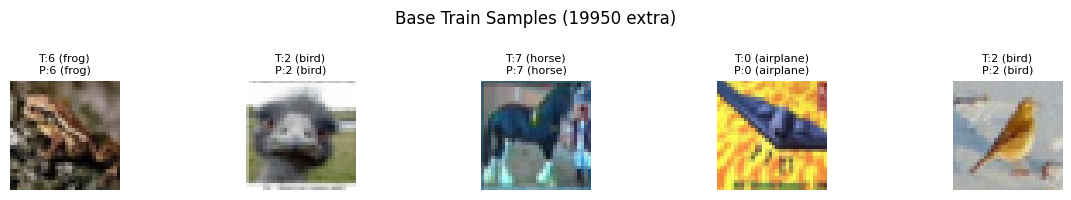

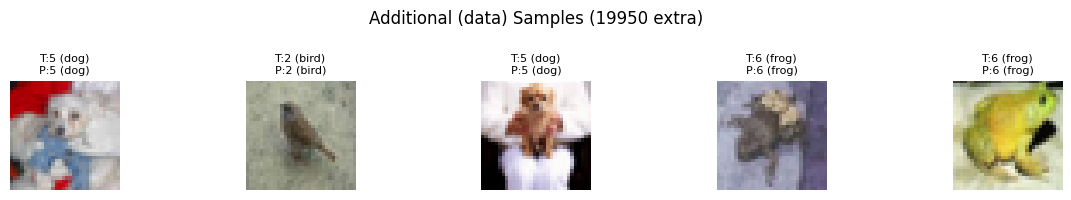

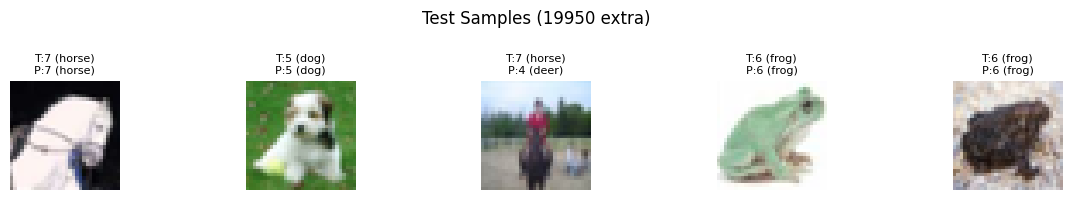

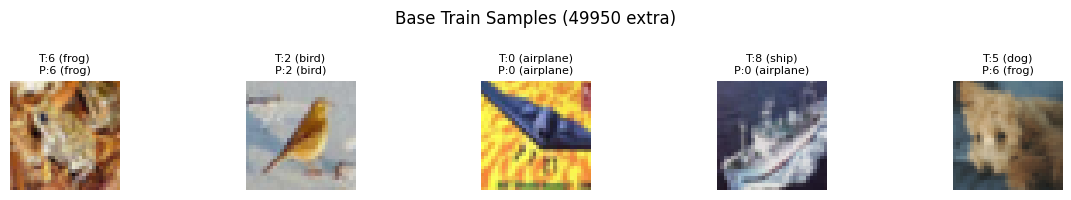

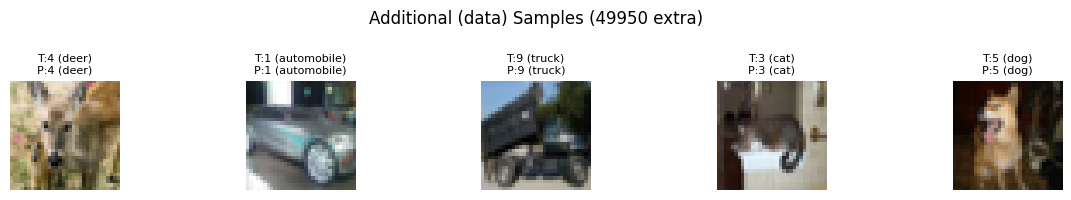

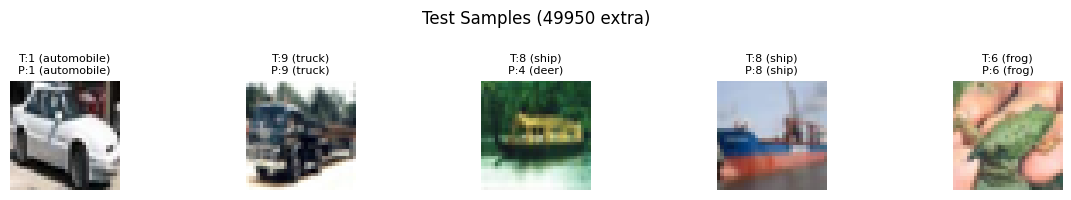

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_450.pt
Saved model: models_and_data/model_additional_450.pt
✅ Model saved to models_and_data\model_additional_1950.pt
Saved model: models_and_data/model_additional_1950.pt
✅ Model saved to models_and_data\model_additional_4950.pt
Saved model: models_and_data/model_additional_4950.pt
✅ Model saved to models_and_data\model_additional_19950.pt
Saved model: models_and_data/model_additional_19950.pt
✅ Model saved to models_and_data\model_additional_49950.pt
Saved model: models_and_data/model_additional_49950.pt
